# SOG Freshwater Chemistry Sensitivity Notebook
This is the model sensitivity notebook
### Sections
   1. [Define Local Functions](#Define-Local-Functions)
   2. [Load and Process Data](#Load-and-Process-Data)
   3. [**Make Figures**](#Make-Figures)
       * [Flow Dependence Figures](#Flow-Dependence-Figures)
       * [SOG Timeseries Figures](#SOG-Timeseries-Figures)
       * [SOG Salinity Average Figures](#SOG-Salinity-Average-Figures)
       * [Salinity Space Figures](#Salinity-Space-Figures)

In [36]:
import numpy as np
import cmocean
import os
import SOG_loader
import carbonate
import gsw
import yaml
import matplotlib.pyplot as plt
from salishsea_tools import utilities
from datetime import datetime, timedelta
from matplotlib import cm
from scipy import io, signal
from matplotlib.dates import DateFormatter

%matplotlib inline

## Define Local Functions

**`parse_run_path:`** Parses a results path into the year, TA, and DIC:TA keys

In [88]:
def parse_run_path(path, keys):
    """Parses a results path into the year, TA, and DIC:TA keys
    """
    
    params = {}
    string = os.path.split(path)[1]
    params['year'] = string.split('_')[0]
    chemstr = string.split(keys[0], maxsplit=1)[1].split(keys[1])
    params[keys[0]] = chemstr[0]
    params[keys[1]] = chemstr[1]
    
    return params

**`calc_mixing_curve:`** Calculates the linear physical mixing line between freshwater and seawater chemistry endmembers

In [109]:
def calc_mixing_curve(TA, DICTA, S=[0, 30], T=[10, 10], P=[0, 0], PO4=[0, 0], Si=[0, 0], mix_bin=100):
    """Calculates the linear physical mixing line between freshwater and seawater chemistry endmembers
    """
    
    # Create endmembers dict
    DIC = [ta * dicta for ta, dicta in zip(TA, DICTA)]
    endmembers = {'TA': TA, 'DIC': DIC, 'S': S, 'T': T, 'P': P, 'PO4': PO4, 'Si': Si}
    mix = {}
    
    # Generate mixing curves
    for key in endmembers:
        mix[key] = np.arange(mix_bin) / (mix_bin-1) * np.diff(endmembers[key]) + endmembers[key][0]
    
    # pH mixing curves
    CO2 = carbonate.calc_carbonate(
        [mix['TA'], mix['DIC']], mix['PO4'], mix['Si'], mix['T'], mix['S'], mix['P'], params=['TA', 'TC'],
    )
    mix['pH'], mix['OmegaA'], mix['pCO2'] = CO2['pH'], CO2['OmegaA'], CO2['pCO2']
    
    return mix

**`load_SOG_dict:`** Loads SOG timeseries results across freshwater TA runs into a single dictionary

In [24]:
def load_SOG_dict(results, path):
    """Loads SOG timeseries results across freshwater TA runs into a single dictionary
    """
    
    # Parse run path
    params = parse_run_path(path, ['TA', 'DICTA'])
    year, TA, DICTA = params['year'], params['TA'], params['DICTA']
    year = int(year)
    
    # Initialize run dict
    results[DICTA][TA][year] = {}
    
    # Load timeseries
    TS_phys = SOG_loader.load_TS(os.path.join(path, 'timeseries/std_phys_SOG.out'))
    TS_chem = SOG_loader.load_TS(os.path.join(path, 'timeseries/std_chem_SOG.out'))
    TS_bio = SOG_loader.load_TS(os.path.join(path, 'timeseries/std_bio_SOG.out'))
    
    # Extract physics fields
    results[DICTA][TA][year]['t'] = TS_phys['3 m avg temperature']                 # in situ temperature [deg C]
    results[DICTA][TA][year]['SP'] = TS_phys['3 m avg salinity']                   # practical salinity  [PSS 78]
    
    # Calculate and assign TEOS-10 properties
    results[DICTA][TA][year]['SR'] = gsw.conversions.SR_from_SP(results[DICTA][TA][year]['SP'])
    results[DICTA][TA][year]['CT'] = gsw.conversions.CT_from_t(
        results[DICTA][TA][year]['SR'], results[DICTA][TA][year]['t'], 0,
    )
    results[DICTA][TA][year]['rho'] = gsw.density.rho(results[DICTA][TA][year]['SR'], results[DICTA][TA][year]['CT'], 0)
    
    # Extract bio and chem fields
    results[DICTA][TA][year]['NO3'] = TS_bio['3 m avg nitrate concentration'] * 1e3 / results[DICTA][TA][year]['rho']
    results[DICTA][TA][year]['NH4'] = TS_bio['3 m avg ammonium concentration'] * 1e3 / results[DICTA][TA][year]['rho']
    results[DICTA][TA][year]['Si'] = TS_bio['3 m avg silicon concentration'] * 1e3 / results[DICTA][TA][year]['rho']
    results[DICTA][TA][year]['DIC'] = TS_chem['3 m avg DIC concentration'] * 1e3 / results[DICTA][TA][year]['rho']
    results[DICTA][TA][year]['TA'] = TS_chem['3 m avg alkalinity'] * 1e3 / results[DICTA][TA][year]['rho']
    
    # Calculate CO2 parameters
    CO2 = carbonate.calc_carbonate(
        [results[DICTA][TA][year]['TA'], results[DICTA][TA][year]['DIC']],         # [TA, DIC]
        (results[DICTA][TA][year]['NO3'] + results[DICTA][TA][year]['NH4']) / 16,  # total phosphate (estimated from N)
        results[DICTA][TA][year]['Si'],                                            # dissolved silica
        results[DICTA][TA][year]['t'],                                             # in situ temperature
        results[DICTA][TA][year]['SP'],                                            # practical salinity
        0,                                                                         # pressure
        params=['TA', 'TC'],
    )
    
    # Assign CO2 parameters
    results[DICTA][TA][year]['pH'] = CO2['pH']                                     # pH [total scale]
    results[DICTA][TA][year]['pCO2'] = CO2['pCO2']                                 # CO2 partial pressure [uatm]
    results[DICTA][TA][year]['OmegaA'] = CO2['OmegaA']                             # aragonite saturation stat
    
    return results

## Load and Process Data

Load SOG timeseries results into dictionary

In [29]:
# Load SOG results
with open('/ocean/bmoorema/research/SOG/SOG-runsets/river_chemistry/run_list.yaml', 'r') as f:
    run_list = yaml.load(f)
SOG_results = {
    '1032': {'250': {}, '500': {}, '750': {}, '1000': {}, '1250': {}, 'var': {}},
    '1089': {'250': {}, '500': {}, '750': {}, '1000': {}, '1250': {}, 'var': {}},
    '1226': {'250': {}, '500': {}, '750': {}, '1000': {}, '1250': {}, 'var': {}},
}
bar = utilities.statusbar('Loading ...')
for path in bar(run_list['run_list']):
    SOG_results = load_SOG_dict(SOG_results, path)

Loading ... 100% (216 of 216) |#####################################################################|Time: 0:11:53


Load Fraser River flow (Q) record into dictionary and calculate dQ/dt

In [30]:
# Load Fraser Record
Fraser = {}
data = io.loadmat('/ocean/rich/home/metro/fraser/FRASER.mat')
Fraser['flow'] = data['fraser'][0][0][2].flatten()
Fraser['flow_filter'] = signal.filtfilt(*signal.butter(2, 0.1), Fraser['flow'])
Fraser['dQdt'] = np.diff(Fraser['flow_filter'])/24
Fraser['dQdt'] = np.append(Fraser['dQdt'][0], Fraser['dQdt'])
Fraser['date'] = [
    datetime.fromordinal(int(mtime[0]) - 366) +
    timedelta(days=float(mtime)%1)
    for mtime in data['fraser'][0][0][1]
]

Create index to bound individual years of flow and sort years by freshet size

In [200]:
# Sort years by freshet
index_flow = {}
freshet = []
for year in range(2001, 2013):
    index_flow[year] = [
        abs(np.array(Fraser['date']) - datetime(year, 1, 1) - timedelta(days=yearday)).argmin()
        for yearday in [0, 365]
    ]
    freshet.append(Fraser['flow_filter'][slice(*index_flow[year])].max())
    #freshet.append(Fraser['flow'][slice(*index_flow[year])].sum())
years = np.arange(2001, 2013)[np.array(freshet).argsort()]

Define lists of TA and DIC:TA scenarios for iteration

In [71]:
TAs = ['250', '500', '750', '1000', '1250']
DICTAs = ['1032', '1089', '1226']

Define plotting properties for each year into a master dictionary `plot_props`

In [207]:
# Plotting properties
plot_props = {}
for index, year in enumerate(years):
    plot_props[year] = {'bgcolor': None, 'edgecolor': None, 'marker': 'o', 'size': 6, 'width': 1.5, 'zorder': 0}
    plot_props[year]['color'] = cm.get_cmap(cmocean.cm.haline)(index/11)
plot_props[2010] = {'color': 'r', 'bgcolor': 'mistyrose', 'edgecolor': 'k', 'marker': '*', 'size': 16, 'width': 2, 'zorder': 10}
plot_props[2012] = {'color': 'k', 'bgcolor': 'lightgray', 'edgecolor': 'k', 'marker': '*', 'size': 16, 'width': 2, 'zorder': 10}

## Make Figures

### Flow Dependence Figures

These figures are designed to show the seasonality and interannual variability of Fraser River flow, and the sensitivity of the model to flow-dependent changes in freshwater TA. All model results are comparisons between the flow dependent (dQ/dt) and constant (750 umol/kg) TA$_f$ cases at (DIC:TA)$_f$ = 1.089 (middle case)
   1. Fraser River hydrograph at Hope
   2. Flow dependent freshwater TA (TA$_f$) based on dQ/dt
   3. $\Delta$pH
   4. $\Delta\Omega_A$

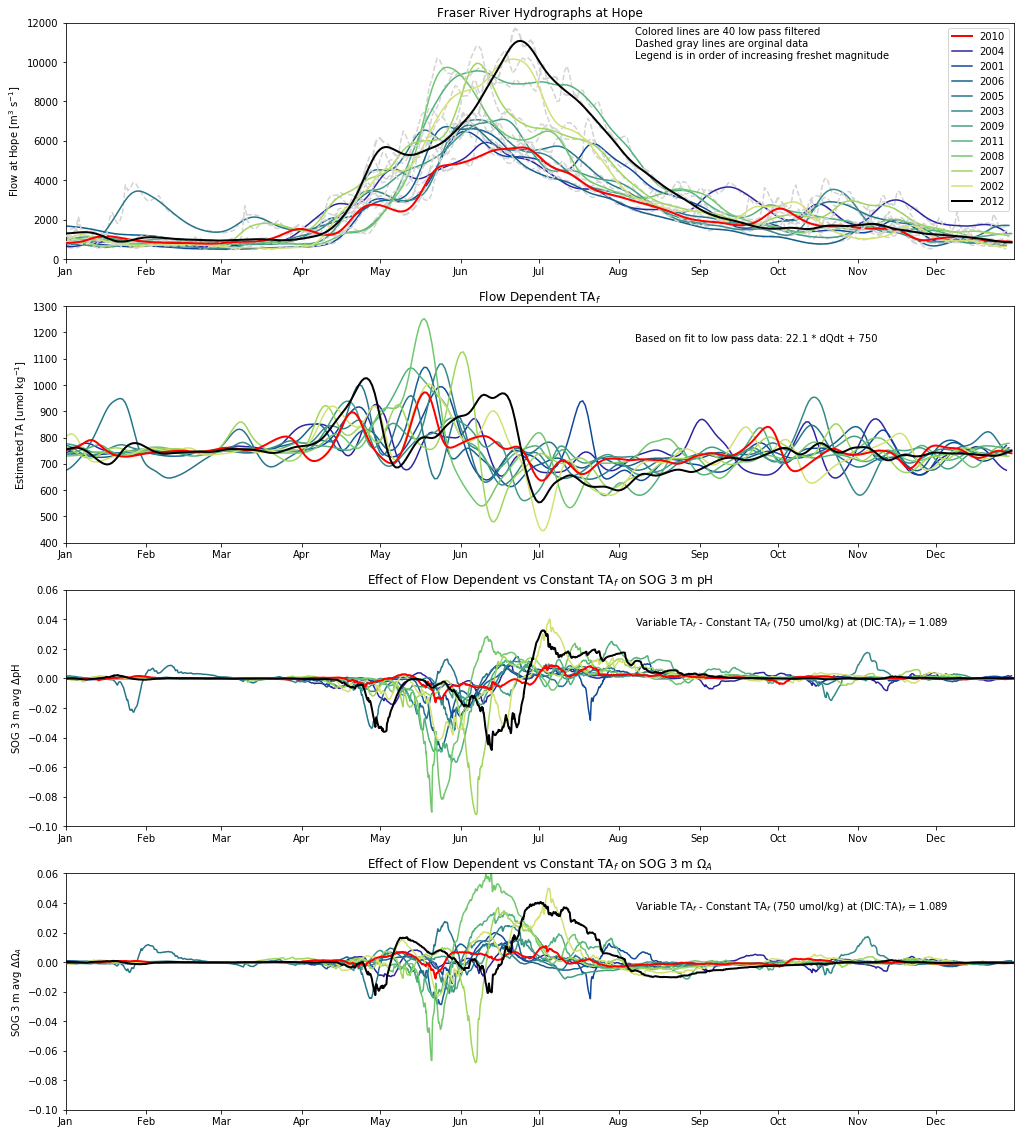

In [208]:
# Make figure axes
fig, axs = plt.subplots(4, 1, figsize=(17, 20))

# Plot formatters
ylims = [[0, 12000], [400, 1300], [-0.1, 0.06], [-0.1, 0.06]]
ylabels = [
    'Flow at Hope [m$^{3}$ s$^{-1}$]',
    'Estimated TA [umol kg$^{-1}$]',
    'SOG 3 m avg $\Delta$pH',
    'SOG 3 m avg $\Delta\Omega_A$',
]
titles = [
    'Fraser River Hydrographs at Hope',
    'Flow Dependent TA$_f$',
    'Effect of Flow Dependent vs Constant TA$_f$ on SOG 3 m pH',
    'Effect of Flow Dependent vs Constant TA$_f$ on SOG 3 m $\Omega_A$',
]
annotations = [
    (
        'Colored lines are 40 low pass filtered\n' +
        'Dashed gray lines are orginal data\n' +
        'Legend is in order of increasing freshet magnitude'
    ),
    'Based on fit to low pass data: 22.1 * dQdt + 750',
    'Variable TA$_f$ - Constant TA$_f$ (750 umol/kg) at (DIC:TA)$_f$ = 1.089',
    'Variable TA$_f$ - Constant TA$_f$ (750 umol/kg) at (DIC:TA)$_f$ = 1.089',
]

# Loop through years
for year in years:
    date = (np.array(Fraser['date'])[slice(*index_flow[year])] - timedelta(days=(int(year) - 2012)*365))
    axs[0].plot(
        date, Fraser['flow'][slice(*index_flow[year])], '--', color='lightgrey',
        linewidth=plot_props[year]['width'], zorder=plot_props[year]['zorder'],
    )
    axs[0].plot(
        date, Fraser['flow_filter'][slice(*index_flow[year])], '-', color=plot_props[year]['color'],
        linewidth=plot_props[year]['width'], zorder=plot_props[year]['zorder'], label=f'{year:d}',
    )
    axs[1].plot(
        date, 22.1*Fraser['dQdt'][slice(*index_flow[year])] + 750, '-', color=plot_props[year]['color'],
        linewidth=plot_props[year]['width'], zorder=plot_props[year]['zorder'],
    )
    date = (
        SOG_results['1089']['750'][year]['pH'].date.values.astype('datetime64[s]').astype(datetime) -
        timedelta(days=(int(year) - 2012)*365)
    )
    axs[2].plot(
        date, SOG_results['1089']['var'][year]['pH'] - SOG_results['1089']['750'][year]['pH'],
        color=plot_props[year]['color'], linewidth=plot_props[year]['width'], zorder=plot_props[year]['zorder'],
    )
    axs[3].plot(
        date, SOG_results['1089']['var'][year]['OmegaA'] - SOG_results['1089']['750'][year]['OmegaA'],
        color=plot_props[year]['color'], linewidth=plot_props[year]['width'], zorder=plot_props[year]['zorder'],
    )

# Format plots
for ax, ylim, ylabel, title, annotation in zip(axs, ylims, ylabels, titles, annotations):
    ax.set_xlim(['2012 Jan 1', '2012 Dec 31'])
    ax.xaxis.set_major_formatter(DateFormatter('%b'))
    ax.set_ylim(ylim)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.text(0.6, 0.85, annotation, transform=ax.transAxes)

axs[0].legend()
plt.show()

### SOG Timeseries Figures

These figures are designed to both communicate the actual cycles of model chemistry variables throughout the year, and the dramatic difference between low (2010) and high (2012) flow years. All timeseries plotted are 3 m averages for 2010 and 2012 only at (DIC:TA)$_f$ = 1.089
   1. DIC:TA
   2. pH
   3. $\Omega_A$

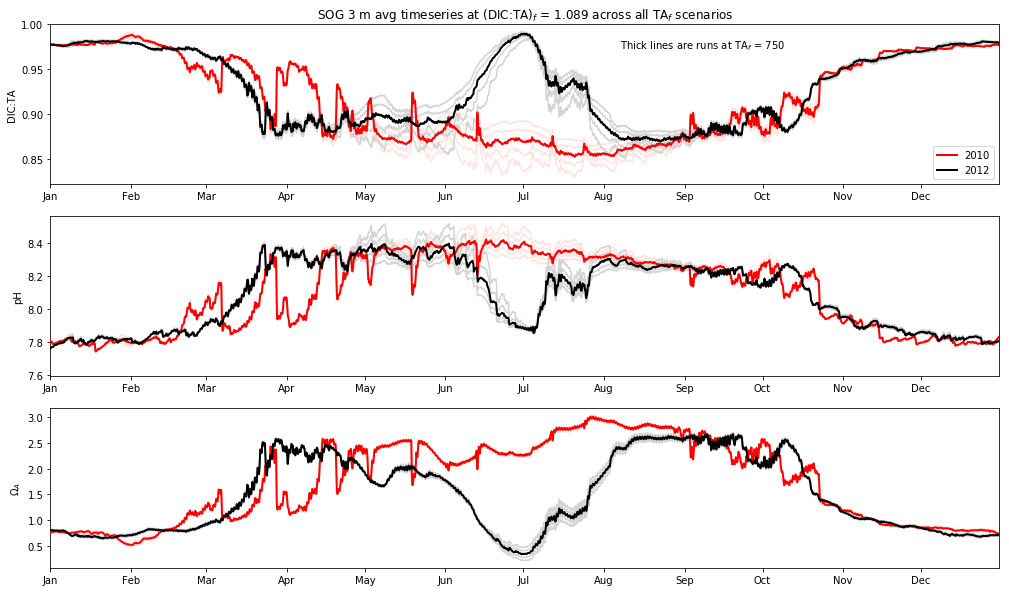

In [209]:
# Make figure axes
fig, axs = plt.subplots(3, 1, figsize=(17, 10))

for year in [2010, 2012]:
    date = (
        SOG_results['1089']['750'][year]['pH'].date.values.astype('datetime64[s]').astype(datetime) -
        timedelta(days=(int(year) - 2012)*365)
    )
    for TA in TAs:
        axs[0].plot(
            date, SOG_results['1089'][TA][year]['DIC'] / SOG_results['1089'][TA][year]['TA'],
            color=plot_props[year]['bgcolor'],
        )
        axs[1].plot(date, SOG_results['1089'][TA][year]['pH'], color=plot_props[year]['bgcolor'])
        axs[2].plot(date, SOG_results['1089'][TA][year]['OmegaA'], color=plot_props[year]['bgcolor'])
        
    axs[0].plot(
            date, SOG_results['1089']['750'][year]['DIC'] /
            SOG_results['1089']['750'][year]['TA'],
            color=plot_props[year]['color'], linewidth=plot_props[year]['width'],
            zorder=plot_props[year]['zorder'], label=str(year),
    )
    axs[1].plot(
        date, SOG_results['1089']['750'][year]['pH'], color=plot_props[year]['color'],
        linewidth=plot_props[year]['width'], zorder=plot_props[year]['zorder'],
    )
    axs[2].plot(
        date, SOG_results['1089']['750'][year]['OmegaA'], color=plot_props[year]['color'],
        linewidth=plot_props[year]['width'], zorder=plot_props[year]['zorder'],
    )

for ax, label in zip(axs, ['DIC:TA', 'pH', '$\Omega_A$']):
    ax.set_xlim(['2012 Jan 1', '2012 Dec 31'])
    ax.xaxis.set_major_formatter(DateFormatter('%b'))
    ax.set_ylabel(label)

axs[0].legend(loc=4)
axs[0].text(0.6, 0.85, 'Thick lines are runs at TA$_f$ = 750', transform=axs[0].transAxes)
axs[0].set_title('SOG 3 m avg timeseries at (DIC:TA)$_f$ = 1.089 across all TA$_f$ scenarios')
plt.show()

### SOG Salinity Average Figures

These figures are designed compress the SOG results using a salinity average to show the overall effect of varying freshwater TA and DICTA on the model variables. The columns vary (DIC:TA)$_f$ and the rows show the following model results. Colors are the same as in the flow dependence figures.
   1. DIC:TA
   2. pH
   3. $\Omega_A$

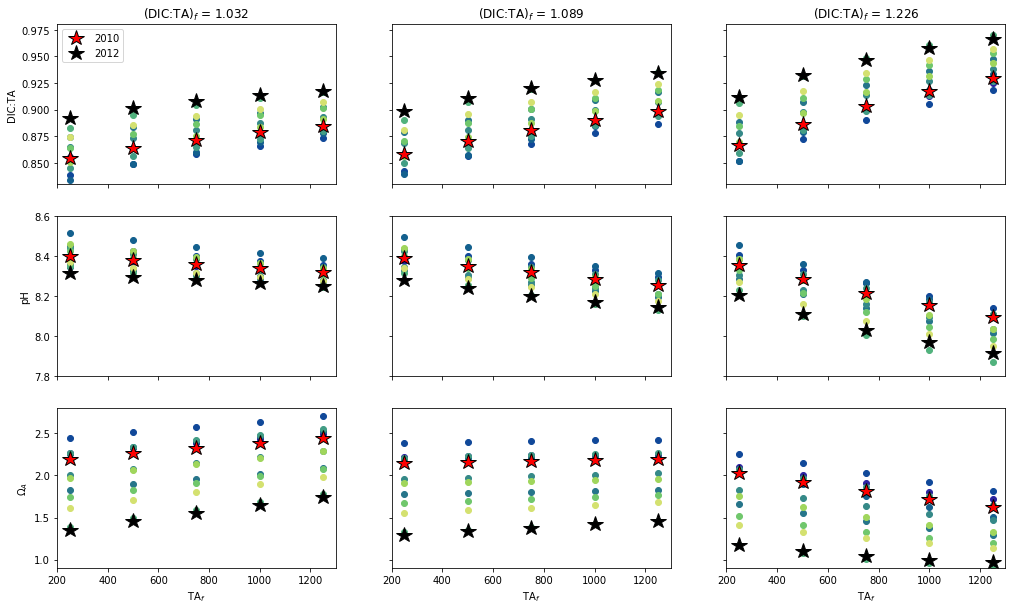

In [210]:
# Make figure axes
fig, axs = plt.subplots(3, 3, figsize=(17, 10))

params = ['DICTA', 'pH', 'OmegaA']
ylims = [[0.83, 0.98], [7.8, 8.6], [0.9, 2.8]]
ylabels = ['DIC:TA', 'pH', '$\Omega_A$']

# Loop through plots
for row, param, lim, label in zip(axs, params, ylims, ylabels):
    for ax, DICTA in zip(row, DICTAs):
        
        # Deal with axis lims, ticks, and labels
        ax.set_ylim(lim)
        if param is 'DICTA':
            ax.set_title(f'(DIC:TA)$_f$ = {int(DICTA)*1e-3:.3f}')
        if param is not 'OmegaA':
            ax.xaxis.set_ticklabels('')
        else:
            ax.set_xlabel('TA$_f$')
        if DICTA is not '1032':
            ax.yaxis.set_ticklabels('')
        else:
            ax.set_ylabel(label)
        
        # Loop throught TA scenarios
        for TA in TAs:
            for year in years:
                label = None
                if TA is '750' and (year == 2010 or year == 2012):
                    label = str(year)
                index_sal = SOG_results[DICTA][TA][year]['SP'] < 20
                if param is 'pH':
                    val = SOG_results[DICTA][TA][year]['pH'][index_sal].mean()
                elif param is 'OmegaA':
                    val = SOG_results[DICTA][TA][year]['OmegaA'][index_sal].mean()
                elif param is 'DICTA':
                    val = (
                        SOG_results[DICTA][TA][year]['DIC'][index_sal] / 
                        SOG_results[DICTA][TA][year]['TA'][index_sal]
                    ).mean()
                ax.plot(
                    int(TA), val, marker=plot_props[year]['marker'], color=plot_props[year]['color'],
                    markeredgecolor=plot_props[year]['edgecolor'],  markersize=plot_props[year]['size'],
                    zorder=plot_props[year]['zorder'], linestyle='', label=label,
                )
axs[0, 0].legend(loc=2)
plt.show()

### Salinity Space Figures

These figures are designed to demonstrate how the SOG model results differ from the theoretical two-endmember mixing curves. The following endmember cases plotted are shown:
   * (DIC:TA)$_f$ = 1.032 (blue)
   * (DIC:TA)$_f$ = 1.090 (black)
   * (DIC:TA)$_f$ = 1.226 (red)
   * TA$_f$ = 500 umol/kg (solid)
   * TA$_f$ = 1000 umol/kg (dashed line or open symbol)
   
The three subplots show the following estuarine chemical variables:
   1. DIC:TA
   2. pH
   3. $\Omega_A$

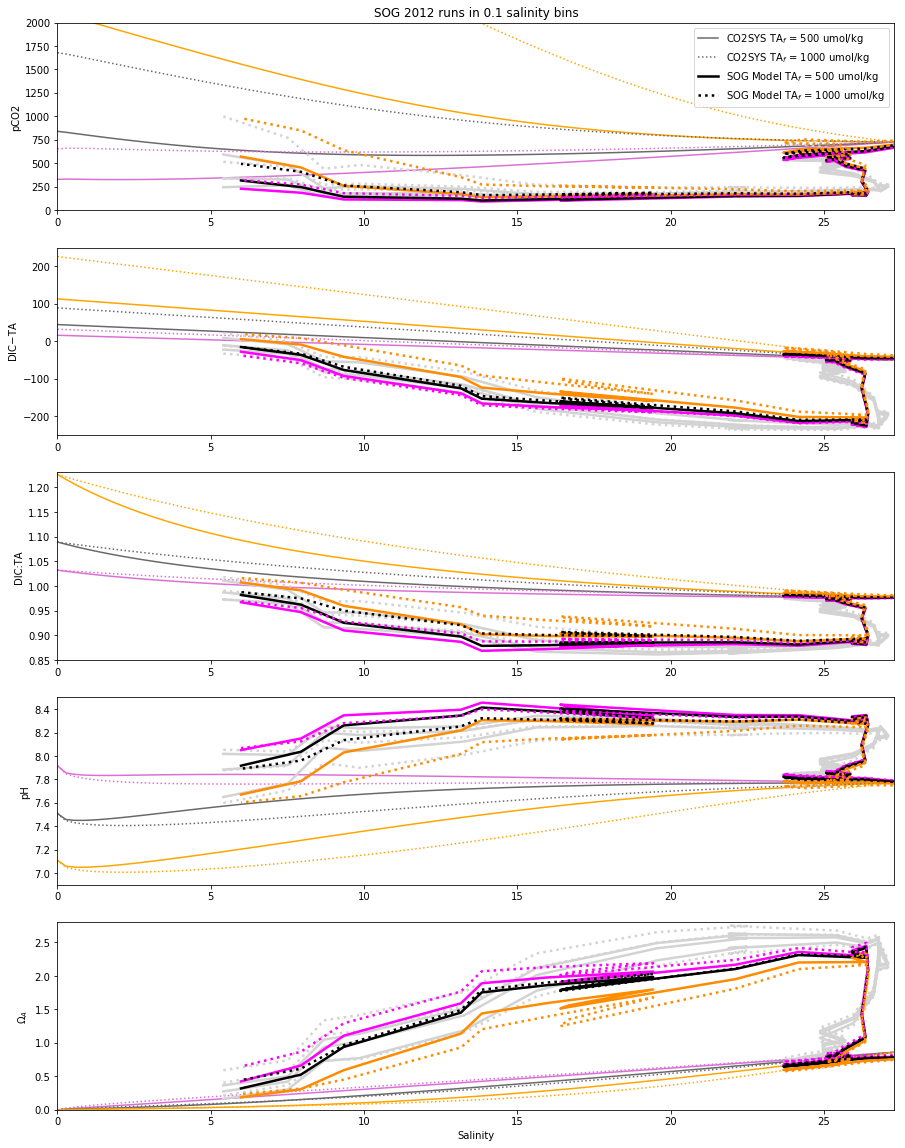

In [292]:
# Make figure axes
fig, axs = plt.subplots(5, 1, figsize=(15, 20))

# Plot parameters
year = 2012
params = ['pCO2', 'DICminusTA', 'DICTA', 'pH', 'OmegaA']
ylims = [[0, 2000], [-250, 250], [0.85, 1.23], [6.9, 8.5], [0, 2.8]]
ylabels = ['pCO2', 'DIC$-$TA', 'DIC:TA', 'pH', '$\Omega_A$']
axs[0].set_title('SOG 2012 runs in 0.1 salinity bins')
axs[4].set_xlabel('Salinity')

# Seawater endmembers
endmember_sea = {'TA': 2020, 'DICTA': 0.975, 'T': 9, 'S': 27.3, 'P': 0, 'PO4': 2, 'Si': 50}

tindex = [
    abs(SOG_results['1089']['750'][year]['pH'].date.values.astype('datetime64[s]').astype(datetime) -
    datetime(year, month, 1)).argmin() for month in [1, 7]
]

# Loop through TA and DICTA endmembers
for TA, linestyle, fillstyle in zip(['500', '1000'], ['-', ':'], ['full', 'none']):
    for DICTA, color, bgcolor in zip(DICTAs, ['magenta', 'k', 'darkorange'], ['orchid', 'dimgray', 'orange']):
        
        # Calculate two endmember mixing curves
        mix = calc_mixing_curve(
            [int(TA), endmember_sea['TA']], [int(DICTA)*1e-3, endmember_sea['DICTA']],
            S=[0, endmember_sea['S']], T=[10, endmember_sea['T']], PO4=[0, endmember_sea['PO4']],
            Si=[0, endmember_sea['Si']],
        )
        
        # Loop through subplots
        for ax, param, ylim, ylabel in zip(axs, params, ylims, ylabels):
            
            # Set axis properties and plot label
            ax.set_xlim([0, 27.3])
            ax.set_ylim(ylim)
            ax.set_ylabel(ylabel)
            label = None
            if DICTA is '1089':
                label = f'CO2SYS TA$_f$ = {TA} umol/kg'
            
            # Plot mixing curves
            if param is 'DICTA':
                y = mix['DIC']/mix['TA']
            elif param is 'DICminusTA':
                y = mix['DIC']-mix['TA']
            else:
                y = mix[param]
            ax.plot(mix['S'], y, '-', color=bgcolor, linestyle=linestyle, label=label)
            
            # Loop through salinity bins to overplot model results
            #x_list = []
            #y_list = []
            #for S_index in np.arange(0, 30, 0.1):
            #    index = (
            #        (SOG_results[DICTA][TA][year]['SP'][tindex:] > S_index) &
            #        (SOG_results[DICTA][TA][year]['SP'][tindex:] < S_index + 1)
            #    )
            #    x_list.append(SOG_results[DICTA][TA][year]['SP'][tindex:][index].mean())
            #    if param is 'DICTA':
            #        y_list.append(
            #            SOG_results[DICTA][TA][year]['DIC'][tindex:][index].mean() /
            #            SOG_results[DICTA][TA][year]['TA'][tindex:][index].mean()
            #        )
            #    elif param is 'DICminusTA':
            #        y_list.append(
            #            SOG_results[DICTA][TA][year]['DIC'][tindex:][index].mean() -
            #            SOG_results[DICTA][TA][year]['TA'][tindex:][index].mean()
            #        )
            #    else:
            #        y_list.append(SOG_results[DICTA][TA][year][param][tindex:][index].mean())
            #if DICTA is '1089':
            #    label=f'SOG Model TA$_f$ = {TA} umol/kg'
            #ax.plot(x_list, y_list, color=color, linestyle=linestyle, linewidth=2.5, label=label)

            x_list = SOG_results[DICTA][TA][year]['SP'][slice(*tindex)].resample('W', 'date')
            x_bg = SOG_results[DICTA][TA][year]['SP'][tindex[1]:].resample('W', 'date')
            if param is 'DICTA':
                y_list = (
                    SOG_results[DICTA][TA][year]['DIC'] /
                    SOG_results[DICTA][TA][year]['TA']
                )[slice(*tindex)].resample('W', 'date')
                y_bg = (
                    SOG_results[DICTA][TA][year]['DIC'] /
                    SOG_results[DICTA][TA][year]['TA']
                )[tindex[1]:].resample('W', 'date')
            elif param is 'DICminusTA':
                y_list = (
                    SOG_results[DICTA][TA][year]['DIC'] -
                    SOG_results[DICTA][TA][year]['TA']
                )[slice(*tindex)].resample('W', 'date')
                y_bg = (
                    SOG_results[DICTA][TA][year]['DIC'] -
                    SOG_results[DICTA][TA][year]['TA']
                )[tindex[1]:].resample('W', 'date')
            else:
                y_list = SOG_results[DICTA][TA][year][param][slice(*tindex)].resample('W', 'date')
                y_bg = SOG_results[DICTA][TA][year][param][tindex[1]:].resample('W', 'date')
            label = None
            if DICTA is '1089':
                label=f'SOG Model TA$_f$ = {TA} umol/kg'
            ax.plot(x_bg, y_bg, color='lightgray', linestyle=linestyle, linewidth=2.5, zorder=5)
            ax.plot(x_list, y_list, color=color, linestyle=linestyle, linewidth=2.5, label=label, zorder=10)
            

# Reorder handles and make legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[0], handles[2], handles[1], handles[3]]
labels = [labels[0], labels[2], labels[1], labels[3]]
axs[0].legend(handles, labels)
plt.show()